# SDSS galaxies


The data is provided in the file <b>"specz_data.txt"</b>. The columns of the file (length of 13) correspond to spectroscopic redshift ('zspec'), RA, DEC, magnitudes in 5 bands - u, g, r, i, z (denoted as 'mu,' 'mg,' 'mr,' 'mi,' 'mz' respectively); Exponential and de Vaucouleurs model magnitude fits ('logExp' and 'logDev' http://www.sdss.org/dr12/algorithms/magnitudes/); zebra fit ('pz_zebra); Neural Network fit ('pz_NN') and its error estimate ('pz_NN_Err') <br>

Our goal is to experiment with our data and run several regression and classification models.
- Regression
    - We will use the magnitude of object in different bands ('mu, mg, mr, mi, mz') and do a regression exercise to estimate the redshift of the object. Hence our feature space is 5.
    - The correct redshift is given by 'zspec', which is the spectroscopic redshift of the object. We will use this for training and testing purpose. 
    
    Sidenote: Some Background of Photometry vs. Spectroscopy
    
    <i>&nbsp; &nbsp; The amount of energy we receive from celestial objects – in the form of radiation – is called the flux, and an astro- nomical technique of measuring the flux is photometry. Flux is usually measured over broad wavelength bands, and with the estimate of the distance to an object, it can infer the object’s luminosity, temperature, size, etc. Usually light is passed through colored filters, and we measure the intensity of the filtered light. 
    
    &nbsp; &nbsp; On the other hand, spectroscopy deals with the spectrum of the emitted light. This tells us what the object is made of, how it is moving, the pressure of the material in it, etc. Note that for faint objects making photometric observation is much easier.
    
    &nbsp; &nbsp; Photometric redshift (photoz) is an estimate of the distance to the object using photometry. Spectroscopic redshift observes the object’s spectral lines and measures their shifts due to the Doppler effect to infer the distance.</i>
    

- Classification
    - We will use the same magnitudes and now also the redshift of the object  ('zspec') to classify the object as either Elleptical or Spiral. 
    - The correct class is given by compring 'logExp' and 'logDev' which are the fits for Exponential and Devocular profiles. If logExp > logDev, its a spiral and vice-versa. We will use this for training and testing purpose. Since the classes are not explicitly given, generate a column for those (Classes can be $\pm 1$. If it is $0$, it does not belong to either of the class.)


In [1]:
import numpy as np
from scipy.integrate import quad
#For plotting
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

##### Cleaning

We first read in our files to create the data (X and Y) for both regression and classification. <br>
We do the following in our data cleaning process -
- Drop the entries that are nan or infinite
- Drop the unrealistic numbers such as 999, -999; and magnitudes that are unrealistic. Since these are absolute magnitudes, they should be positive and high. Lets choose a magnitude limit of 15 as safe bet.
- For classification, drop the entries that do not belong to either of the class


In [2]:
#Read in and create data

fname = 'specz_data.txt'
spec_dat=np.genfromtxt(fname,names=True)
print(spec_dat.dtype.fields.keys())
#convenience variable
zspec = spec_dat['zspec']
pzNN = spec_dat['pz_NN']
#some N redshifts are not defined
pzNN[pzNN < 0] = np.nan

#For Regression
bands = ['u', 'g', 'r','i', 'z' ]
mlim = 15

xdata = np.concatenate([[spec_dat['m%s'%i] for i in bands]]).T
bad = (xdata[:, 0] < mlim) | (xdata[:, 1] < mlim) | (xdata[:, 2] < mlim) & (xdata[:, 3] < mlim) | (xdata[:, 4] < mlim)
xdata = xdata[~bad]
xdata[xdata<0] = 0
ydata = zspec[~bad]

#For classification
classes = np.sign(spec_dat['logExp'] - spec_dat['logDev'])
tmp = np.concatenate([[spec_dat['m%s'%i] for i in bands]]).T
xxdata = np.concatenate([tmp, zspec.reshape(-1, 1)], axis=1)
bad = (classes==0) | (xxdata[:, 0] < mlim) | (xxdata[:, 1] < mlim) | (xxdata[:, 2] < mlim) & (xxdata[:, 3] < mlim) | (xxdata[:, 4] < mlim)
xxdata = xxdata[~bad]
classes = classes[~bad]

dict_keys(['zspec', 'RA', 'DEC', 'mu', 'mg', 'mr', 'mi', 'mz', 'logExp', 'logDev', 'pz_zebra', 'pz_NN', 'pz_NN_Err'])


For regression, the X and Y data (called "xdata" and "ydata," respectively) is cleaned magnitudes (5 feature space) and spectroscopic redshifts respectively.
For classification, X and Y data (called "xxdata" and "classes" respectively) is cleaned magnitudes+spectroscopic redshifts respectively (6 feature space) and classes, respectively.

In [3]:
print('For Regression:')
print('Before: Size of datasets is ', zspec.shape[0])
print('After: Size of datasets is ', xdata.shape[0])
print('')
print('For Classification:')
print('Before: Size of datasets is ', zspec.shape[0])
print('After: Size of datasets is ', xxdata.shape[0])

For Regression:
Before: Size of datasets is  5338
After: Size of datasets is  4535

For Classification:
Before: Size of datasets is  5338
After: Size of datasets is  4147


##### Visualization

The next step should be to visualize the data. <br>

- For regression, we make a histogram for the distribution of the data (spectroscopic redshift) and five 2D histograms of the distribution of the magnitude as function of redshift.

- For classification we make six 1-d histogram for the distribution of the data (6 features - zspec and 5 magnitudes) for both class 1 and -1 separately 

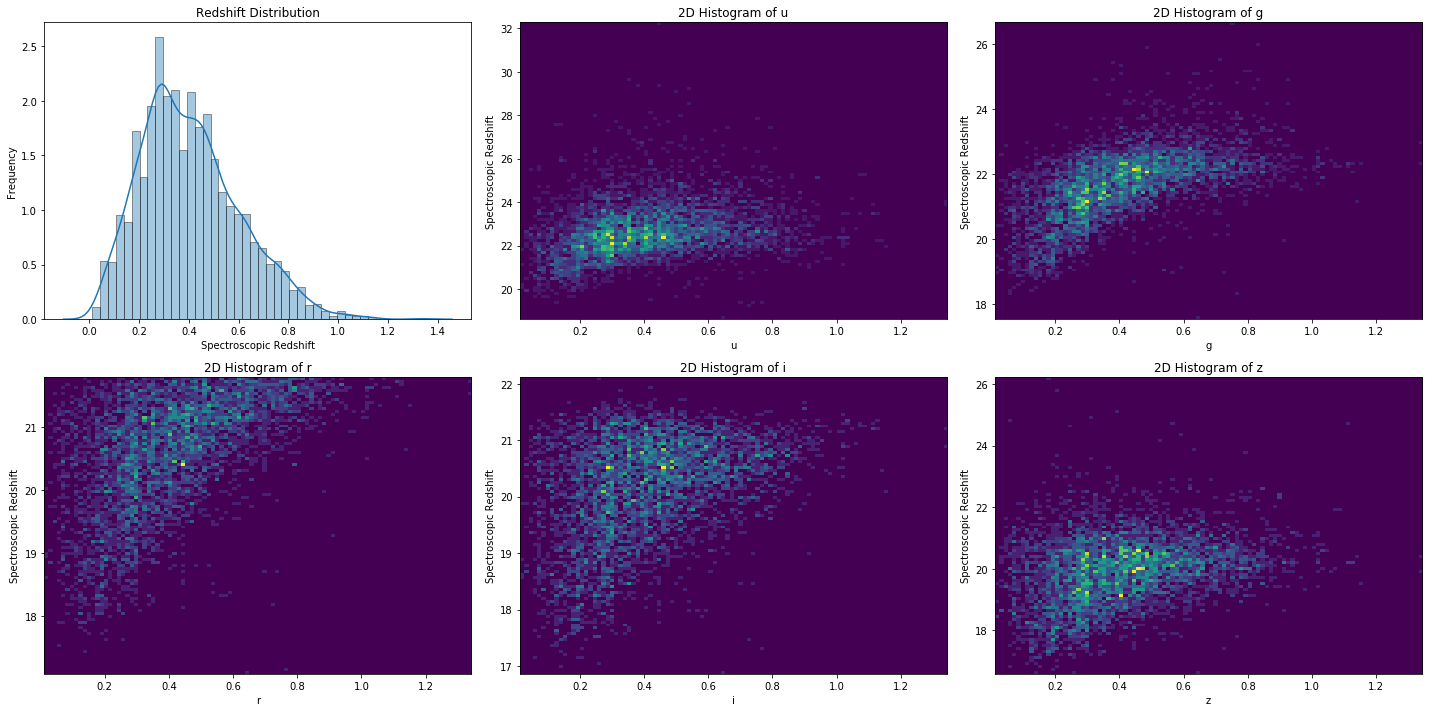

In [4]:
#Regression
plt.figure(figsize = (20,10)) #making 6 histograms
plt.subplot(2,3,1)
import seaborn as sns
sns.distplot(ydata, hist_kws=dict(edgecolor="k"))
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Frequency')
plt.title('Redshift Distribution')
for i in np.arange(5):
    plt.subplot(2,3,2 + i)
    plt.hist2d(ydata, xdata[:,i], bins=100)
    plt.xlabel(bands[i])
    plt.ylabel('Spectroscopic Redshift')
    plt.title('2D Histogram of ' + bands[i])
plt.tight_layout()
plt.show()

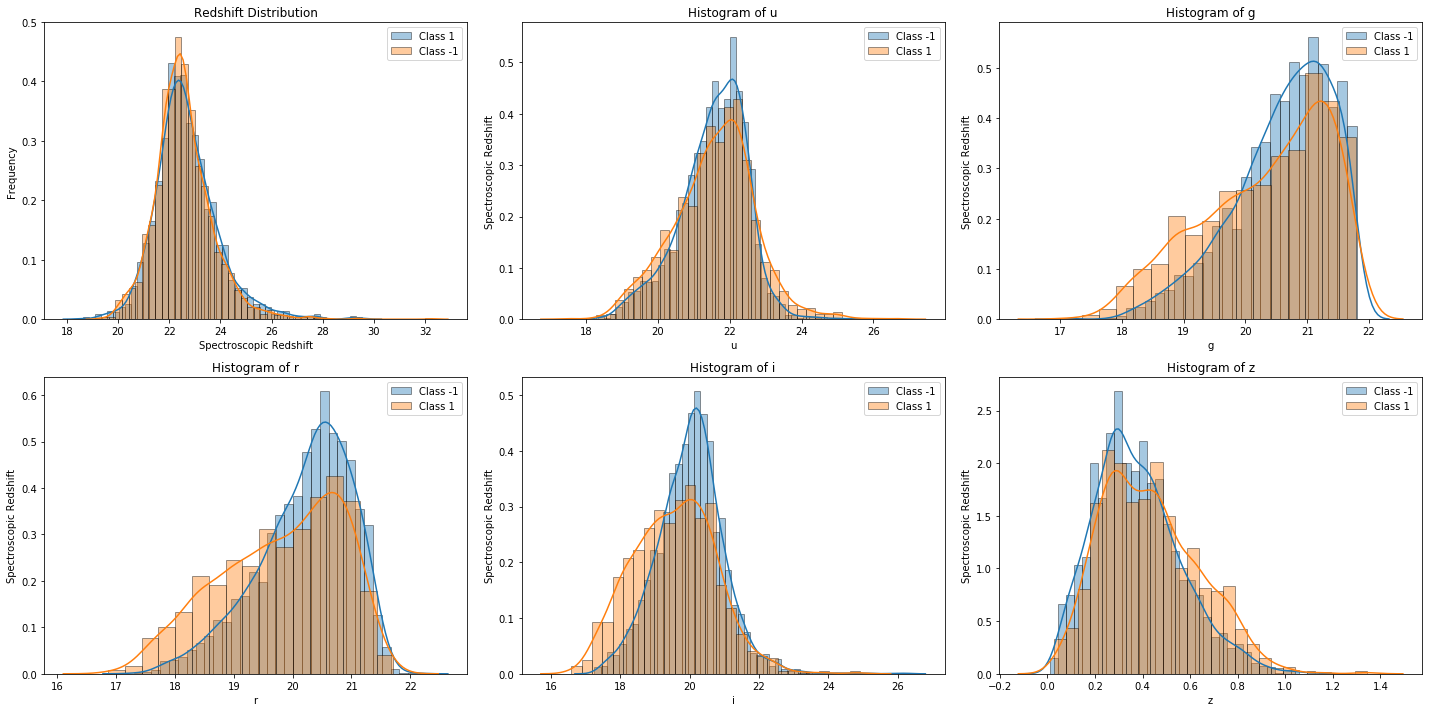

In [5]:
#Classification
plt.figure(figsize = (20,10)) #making 6 histograms
plt.subplot(2,3,1)
import seaborn as sns
sns.distplot(xxdata[classes == 1, 0], hist_kws=dict(edgecolor="k"), label = 'Class 1')
sns.distplot(xxdata[classes == -1, 0], hist_kws=dict(edgecolor="k"), label = 'Class -1')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Frequency')
plt.title('Redshift Distribution')
plt.legend()

for i in np.arange(1,6):
    plt.subplot(2,3,1 + i)
    sns.distplot(xxdata[classes == -1, i], hist_kws=dict(edgecolor="k"), label = 'Class -1')
    sns.distplot(xxdata[classes == 1, i], hist_kws=dict(edgecolor="k"), label = 'Class 1')
    plt.xlabel(bands[i-1])
    plt.ylabel('Spectroscopic Redshift')
    plt.title('Histogram of ' + bands[i-1])
    plt.legend()
plt.tight_layout()
plt.show()



#####  Preprocessing:

- Next, split the sample into training data and the testing data. We will be using the training data to train different algorithms and then compare the performance over the testing data. We'll keep 80% of the data as training data and uses the remaining 20% data for testing.  <br>
- Many algorithms are also not scale invariant, and hence scale the data (different features to a uniform scale). We use StandardScaler from sklearn to center the data to 0 mean and 1 variance.<br><br>

In [6]:
from sklearn import preprocessing

In [7]:
def preprocessed(x_data, y_data, train = 0.8, regression = True):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, train_size = train)
    scale_xdata, scale_ydata = preprocessing.StandardScaler(), preprocessing.StandardScaler()
    if regression:
        #First for train
        scale_xdata.fit(X_train)
        scale_ydata.fit(y_train.reshape(-1, 1))
        scaled_train_data = (scale_xdata.fit_transform(X_train), scale_ydata.fit_transform(y_train.reshape(-1, 1)))
        #Now for test
        scale_xdata, scale_ydata = preprocessing.StandardScaler(), preprocessing.StandardScaler()
        scale_xdata.fit(X_test)
        scale_ydata.fit(y_test.reshape(-1, 1))
        scaled_test_data = (scale_xdata.fit_transform(X_test), scale_ydata.fit_transform(y_test.reshape(-1, 1)))
    else: #Classification
        scale_xdata.fit(X_train)
        #y is already scaled
        scaled_train_data = (scale_xdata.fit_transform(X_train), y_train)
        #Now for test
        scale_xdata, scale_ydata = preprocessing.StandardScaler(), preprocessing.StandardScaler()
        scale_xdata.fit(X_test)
        #y is already scaled
        scaled_test_data = (scale_xdata.fit_transform(X_test), y_test)
    return scaled_train_data, scaled_test_data

#First Regression
reg_train, reg_test = preprocessed(xdata, ydata)

#Next Classification
cla_train, cla_test = preprocessed(xxdata, classes, regression = False)

##### Metrics

The last remaining preperatory step is to write metric for gauging the performance of the algorithm. We write a function that calculates the 'RMS' error given (y_predict, y_truth) to gauge regression and another function to evaluate accuracy of classification. <br>
In addition, for classification, we will also use confusion matrix.

In [8]:
from sklearn.metrics import confusion_matrix

def rms(x, y, scale1=None, scale2=None):
    '''Calculate the rms error given the truth and the prediction
    '''
    mask = np.isfinite(x[:]) & np.isfinite(y[:])
    if scale1 is not None:
        x= scale1.inverse_transform(x)
    if scale2 is not None:
        y = scale2.inverse_transform(y)
    return  np.sqrt(np.mean((x[mask] - y[mask]) ** 2))

def acc(x, y):
    '''Calculate the accuracy given the truth and the prediction
    '''
    mask = np.isfinite(x[:]) & np.isfinite(y[:])
    return  (x == y).sum()/x.size


#### Hyperparameter method

Now, we will be varying hyperparameters to get the best model and build some intuition. There are various ways to do this and we will use Grid Search methodology, trying all the combinations along with some cross-validation scheme. For most part, we will use 4-fold cross validation. <br>
Sklearn provides GridSearchCV functionality for this purpose. <br>

In [9]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Method 1. k Nearest Neighbors

For regression, let us play with grid search using knn to tune hyperparmeters. With the following 3 hyperparameters - 

- Number of neighbors ([2, 3, 5, 10, 15, 20, 25, 50, 100])
- Weights of leaves (Uniform or Inverse Distance weighing)
- Distance metric (Eucledian or Manhattan distance - parameter 'p')

We perform a grid search. We'll list the combination of hyperparameters we tried and evaluate the accuracy (mean test score) and its standard deviation.

In [10]:
from sklearn.neighbors import KNeighborsRegressor

In [11]:
parameters = {'n_neighbors':[2, 3, 5, 10, 15, 20, 25, 50, 100], 'weights':['uniform', 'distance'], 'p':[1, 2]}
knnr = KNeighborsRegressor()
gcknn = GridSearchCV(knnr, parameters, cv=4)
#scaled_training_data = (X_train,  Y_train)
gcknn.fit(*reg_train)
results = gcknn.cv_results_


In [12]:
results['rank_test_score']

array([36, 34, 35, 33, 31, 28, 32, 30, 24, 20, 23, 17, 15,  8, 13,  7, 16,
        5, 14,  1, 19,  3, 18,  2, 21,  4, 22,  6, 25,  9, 26, 10, 27, 11,
       29, 12], dtype=int32)

In [13]:
results['params']

[{'n_neighbors': 2, 'p': 1, 'weights': 'uniform'},
 {'n_neighbors': 2, 'p': 1, 'weights': 'distance'},
 {'n_neighbors': 2, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 2, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'},
 {'n_neighbors': 3, 'p': 1, 'weights': 'distance'},
 {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 3, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'},
 {'n_neighbors': 5, 'p': 1, 'weights': 'distance'},
 {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 5, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'},
 {'n_neighbors': 10, 'p': 1, 'weights': 'distance'},
 {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 10, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 15, 'p': 1, 'weights': 'uniform'},
 {'n_neighbors': 15, 'p': 1, 'weights': 'distance'},
 {'n_neighbors': 15, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors'

In [14]:
results['mean_test_score']

array([0.37727622, 0.38155277, 0.37781833, 0.38217839, 0.43913113,
       0.45028931, 0.43348524, 0.44403366, 0.47890167, 0.50001493,
       0.4869699 , 0.50601949, 0.50926991, 0.54040041, 0.51028889,
       0.54152295, 0.50803947, 0.54623474, 0.5100676 , 0.54905142,
       0.50262324, 0.54705291, 0.50321426, 0.54804325, 0.49869088,
       0.54683387, 0.49688521, 0.54513866, 0.47830807, 0.53604584,
       0.47464661, 0.5331799 , 0.45154871, 0.51676693, 0.44466116,
       0.51172007])

In [15]:
results['std_test_score']

array([0.04687324, 0.04886355, 0.05130549, 0.05617572, 0.03754903,
       0.04157718, 0.0458315 , 0.04984148, 0.0348488 , 0.04000489,
       0.03141436, 0.03817257, 0.02676079, 0.03524325, 0.02826988,
       0.03476256, 0.02011611, 0.02898399, 0.02212124, 0.03085039,
       0.02272352, 0.03032491, 0.02024998, 0.02884533, 0.02778523,
       0.03380625, 0.02176825, 0.02932167, 0.02697329, 0.03340194,
       0.02599417, 0.03149781, 0.0208621 , 0.02774499, 0.02055918,
       0.02821455])

Based on this, we see that the 19th index produces the highest score!

In [16]:
print(results['params'][19])
print('with')
print(results['mean_test_score'][19], '±', results['std_test_score'][19])

{'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
with
0.5490514218125094 ± 0.03085038820311393


Here we fit and score times for all hyperparameter combinations.

In [17]:
#indecies 
p_index = [i['p'] == 1 for i in results['params']]
weight_index = [i['weights'] == 'uniform' for i in results['params']]
nn2 = [i['n_neighbors'] == 2 for i in results['params']]
nn3 = [i['n_neighbors'] == 3 for i in results['params']]
nn5 = [i['n_neighbors'] == 5 for i in results['params']]
nn10 = [i['n_neighbors'] == 10 for i in results['params']]
nn15= [i['n_neighbors'] == 15 for i in results['params']]
nn20 = [i['n_neighbors'] == 20 for i in results['params']]
nn25 = [i['n_neighbors'] == 25 for i in results['params']]
nn50 = [i['n_neighbors'] == 50 for i in results['params']]
nn100 = [i['n_neighbors'] == 100 for i in results['params']]

In [18]:
#Printing out fitting
results['mean_fit_time']

array([0.00072724, 0.00064921, 0.00062841, 0.00062108, 0.00062096,
       0.00062603, 0.000633  , 0.00063872, 0.00066018, 0.00063431,
       0.00062287, 0.00062442, 0.0006482 , 0.00065541, 0.00063974,
       0.00064176, 0.00068426, 0.00067329, 0.000655  , 0.00065821,
       0.00066507, 0.00064474, 0.00069618, 0.00091666, 0.0009132 ,
       0.00064272, 0.00091112, 0.0008347 , 0.00066423, 0.00064611,
       0.00064951, 0.00067157, 0.00063968, 0.00065017, 0.00067574,
       0.00066555])

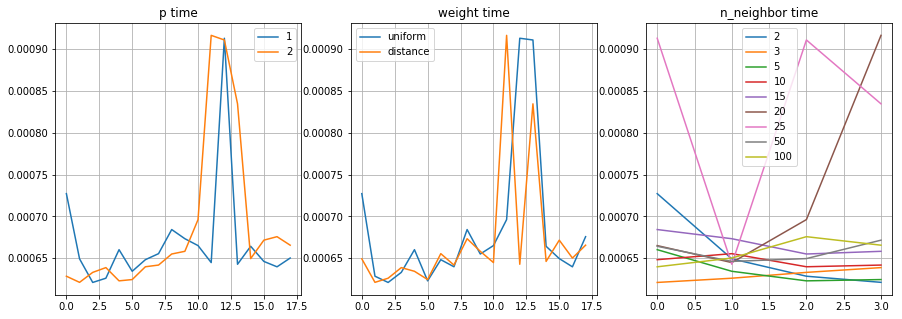

In [19]:
#Plotting mean_fit_time
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.plot(results['mean_fit_time'][p_index], label = '1')
plt.plot(results['mean_fit_time'][~np.array(p_index)], label = '2')
plt.title('p time')
plt.grid()
plt.legend()

plt.subplot(1,3,2)
plt.plot(results['mean_fit_time'][weight_index], label = 'uniform')
plt.plot(results['mean_fit_time'][~np.array(weight_index)], label = 'distance')
plt.title('weight time')
plt.grid()
plt.legend()

#[2, 3, 5, 10, 15, 20, 25, 50, 100]]
plt.subplot(1,3,3)
plt.plot(results['mean_fit_time'][nn2], label = '2')
plt.plot(results['mean_fit_time'][nn3], label = '3')
plt.plot(results['mean_fit_time'][nn5], label = '5')
plt.plot(results['mean_fit_time'][nn10], label = '10')
plt.plot(results['mean_fit_time'][nn15], label = '15')
plt.plot(results['mean_fit_time'][nn20], label = '20')
plt.plot(results['mean_fit_time'][nn25], label = '25')
plt.plot(results['mean_fit_time'][nn50], label = '50')
plt.plot(results['mean_fit_time'][nn100], label = '100')
plt.title('n_neighbor time')
plt.grid()
plt.legend()
plt.show()

In [20]:
#Printing out scoring
results['mean_score_time']

array([0.00488067, 0.00482678, 0.00311077, 0.00321496, 0.00496018,
       0.00505191, 0.00352657, 0.00377452, 0.00581378, 0.00584757,
       0.00402117, 0.00406551, 0.00732154, 0.00739455, 0.00511646,
       0.0051567 , 0.00868702, 0.00874752, 0.00600165, 0.00607324,
       0.00971299, 0.00957823, 0.00778455, 0.01296675, 0.02327794,
       0.01039797, 0.01156163, 0.01017404, 0.01514405, 0.01459628,
       0.01113421, 0.01230562, 0.02152604, 0.02169758, 0.01808184,
       0.01824808])

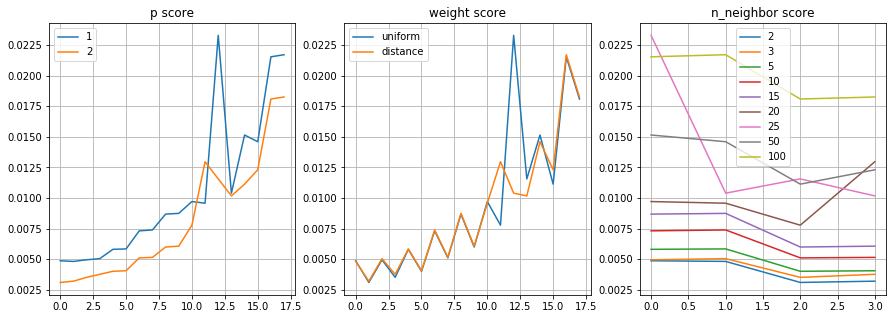

In [21]:
#Plotting mean_score_time
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.plot(results['mean_score_time'][p_index], label = '1')
plt.plot(results['mean_score_time'][~np.array(p_index)], label = '2')
plt.title('p score')
plt.grid()
plt.legend()

plt.subplot(1,3,2)
plt.plot(results['mean_score_time'][weight_index], label = 'uniform')
plt.plot(results['mean_score_time'][~np.array(weight_index)], label = 'distance')
plt.title('weight score')
plt.grid()
plt.legend()

#[2, 3, 5, 10, 15, 20, 25, 50, 100]]
plt.subplot(1,3,3)
plt.plot(results['mean_score_time'][nn2], label = '2')
plt.plot(results['mean_score_time'][nn3], label = '3')
plt.plot(results['mean_score_time'][nn5], label = '5')
plt.plot(results['mean_score_time'][nn10], label = '10')
plt.plot(results['mean_score_time'][nn15], label = '15')
plt.plot(results['mean_score_time'][nn20], label = '20')
plt.plot(results['mean_score_time'][nn25], label = '25')
plt.plot(results['mean_score_time'][nn50], label = '50')
plt.plot(results['mean_score_time'][nn100], label = '100')
plt.title('n_neighbor score')
plt.grid()
plt.legend()
plt.show()

We are curious to see what parameter affects performance the most. Let's make plots of the mean test score for each hyperparameter to get a better tune our model.

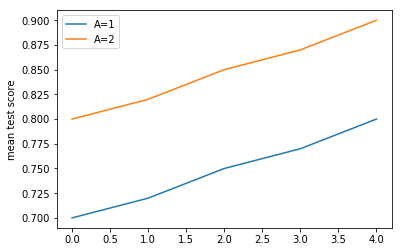

In [22]:
A_1 = [0.7, 0.72, 0.75, 0.77, 0.8]
A_2 = [0.8, 0.82, 0.85, 0.87, 0.9]

plt.plot(A_1, label = "A=1")
plt.plot(A_2, label = "A=2")
plt.ylabel("mean test score")
plt.legend()
plt.show()

This is the plot of the mean test score for A marginalizing over B.

Similarly, we make a plot of the mean test score for each kNN hyperparameter.

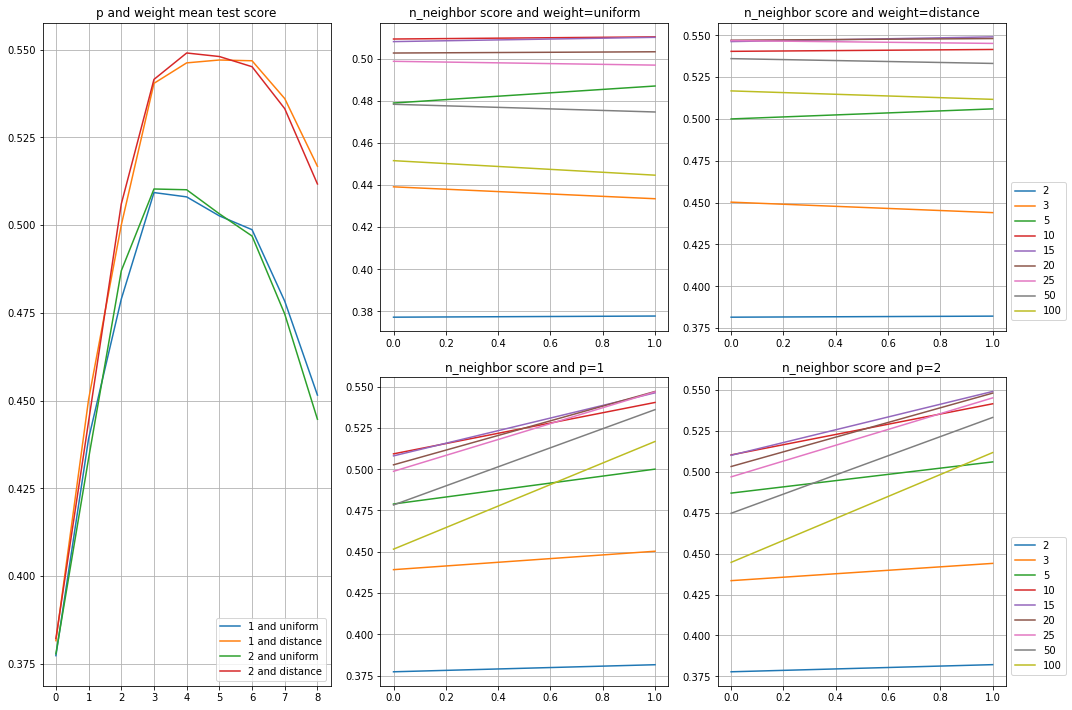

In [23]:
#Plotting mean_score_time
mts = results['mean_test_score']
plt.figure(figsize = (15,10))
plt.subplot(1,3,1)
plt.plot(mts[np.array(p_index) & np.array(weight_index)], label = '1 and uniform')
plt.plot(mts[np.array(p_index) & ~np.array(weight_index)], label = '1 and distance')
plt.plot(mts[~np.array(p_index) & np.array(weight_index)], label = '2 and uniform')
plt.plot(mts[~np.array(p_index) & ~np.array(weight_index)], label = '2 and distance')
plt.title('p and weight mean test score')
plt.grid()
plt.legend()

plt.subplot(2,3,2)
plt.plot(mts[np.array(nn2)& np.array(weight_index)], label = '2')
plt.plot(mts[np.array(nn3)& np.array(weight_index)], label = '3')
plt.plot(mts[np.array(nn5)& np.array(weight_index)], label = '5')
plt.plot(mts[np.array(nn10)& np.array(weight_index)], label = '10')
plt.plot(mts[np.array(nn15)& np.array(weight_index)], label = '15')
plt.plot(mts[np.array(nn20)& np.array(weight_index)], label = '20')
plt.plot(mts[np.array(nn25)& np.array(weight_index)], label = '25')
plt.plot(mts[np.array(nn50)& np.array(weight_index)], label = '50')
plt.plot(mts[np.array(nn100)& np.array(weight_index)], label = '100')
plt.title('n_neighbor score and weight=uniform')
plt.grid()

plt.subplot(2,3,3)
plt.plot(mts[np.array(nn2)&  ~np.array(weight_index)], label = '2')
plt.plot(mts[np.array(nn3)&  ~np.array(weight_index)], label = '3')
plt.plot(mts[np.array(nn5)&  ~np.array(weight_index)], label = '5')
plt.plot(mts[np.array(nn10)& ~np.array(weight_index)], label = '10')
plt.plot(mts[np.array(nn15)& ~np.array(weight_index)], label = '15')
plt.plot(mts[np.array(nn20)& ~np.array(weight_index)], label = '20')
plt.plot(mts[np.array(nn25)& ~np.array(weight_index)], label = '25')
plt.plot(mts[np.array(nn50)& ~np.array(weight_index)], label = '50')
plt.plot(mts[np.array(nn100)& ~np.array(weight_index)], label = '100')
plt.title('n_neighbor score and weight=distance')
plt.grid()
plt.legend(bbox_to_anchor=(1, 0.5))

plt.subplot(2,3,5)
plt.plot(mts[np.array(nn2)& np.array(p_index)], label = '2')
plt.plot(mts[np.array(nn3)& np.array(p_index)], label = '3')
plt.plot(mts[np.array(nn5)& np.array(p_index)], label = '5')
plt.plot(mts[np.array(nn10)& np.array(p_index)], label = '10')
plt.plot(mts[np.array(nn15)& np.array(p_index)], label = '15')
plt.plot(mts[np.array(nn20)& np.array(p_index)], label = '20')
plt.plot(mts[np.array(nn25)& np.array(p_index)], label = '25')
plt.plot(mts[np.array(nn50)& np.array(p_index)], label = '50')
plt.plot(mts[np.array(nn100)& np.array(p_index)], label = '100')
plt.title('n_neighbor score and p=1')
plt.grid()


plt.subplot(2,3,6)
plt.plot(mts[np.array(nn2)&  ~np.array(p_index)], label = '2')
plt.plot(mts[np.array(nn3)&  ~np.array(p_index)], label = '3')
plt.plot(mts[np.array(nn5)&  ~np.array(p_index)], label = '5')
plt.plot(mts[np.array(nn10)& ~np.array(p_index)], label = '10')
plt.plot(mts[np.array(nn15)& ~np.array(p_index)], label = '15')
plt.plot(mts[np.array(nn20)& ~np.array(p_index)], label = '20')
plt.plot(mts[np.array(nn25)& ~np.array(p_index)], label = '25')
plt.plot(mts[np.array(nn50)& ~np.array(p_index)], label = '50')
plt.plot(mts[np.array(nn100)& ~np.array(p_index)], label = '100')
plt.title('n_neighbor score and p=2')
plt.grid()
plt.legend(bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

From the look of these graphs, it looks like weight has a bit of weight (pun intended) in adding to a bit of performance. Making the weight equal distance automatically adds 0.04. n_neighbor score between 10 and 25 increased performance, while too little n (2, 3) or too big n (50, 100) decreased performance. p didn't make much of a difference, however one can see that p = 2 increases performance by around 0.005.

(I combined p and uniform into one graph, as it's easier to distinguish between the hyperparameters this way.)

<span style="color:blue"> <i> 5. You have determined the best combination of hyperparameters and CV schemes. Predict the test y data using the GridSearchCV method. Use the "rms" metric function we defined earlier and calculate the rms error on the test data.  </i></span> <br>

Hint: To determine the rms error, you need:

Truth: given from data (test_data[1]) <br>
Prediction: gridsearch.predict(test_data[0])
(https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)


Now that we've used the best combination of hypterparameters and CV schemes, let's use a Gridsearch to determine these values. We calculate the rms error on our test data.

In [24]:
def rms(x, y, scale1=None, scale2=None):
    '''Calculate the rms error given the truth and the prediction
    '''
    mask = np.isfinite(x[:]) & np.isfinite(y[:])
    if scale1 is not None:
        x= scale1.inverse_transform(x)
    if scale2 is not None:
        y = scale2.inverse_transform(y)
    return  np.sqrt(np.mean((x[mask] - y[mask]) ** 2))

rms(gcknn.predict(reg_test[0]), reg_test[1])

0.6496802233420106

#### Classification

In [25]:
from sklearn.neighbors import KNeighborsClassifier
# http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Here we will look at 4 different type of cross-validation schemes - 
- Kfold
- Stratified Kfold
- Shuffle Split
- Stratified Shuffle Split

Thus, we do four different grid searches. We take the top five combination of hyperparameters the give the highest accuracy from above and rank the performance of CV schemes for each combination.

In [26]:
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit

In [27]:
parameters = {'n_neighbors':[2, 3, 5, 10, 15, 20, 25, 50, 100], 'weights':['uniform', 'distance'], 'p':[1, 2]}
knnc = KNeighborsClassifier()

#Grid Search
gc = GridSearchCV(knnc, parameters, cv=KFold(4, random_state=100))
#Do the fit
gc.fit(*cla_train)

gc2 = GridSearchCV(knnc, parameters, cv=StratifiedKFold(4, random_state = 100))
#Do the fit
gc2.fit(*cla_train)

gc3 = GridSearchCV(knnc, parameters, cv=ShuffleSplit(4, 0.1, random_state = 100))
#Do the fit
gc3.fit(*cla_train)

gc4 = GridSearchCV(knnc, parameters, cv=StratifiedShuffleSplit(4, 0.1, random_state = 100))
#Do the fit
gc4.fit(*cla_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=4, random_state=100, test_size=0.1,
            train_size=None),
       error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [2, 3, 5, 10, 15, 20, 25, 50, 100], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Accuracy for Kfold : 0.763855421686747
Accuracy for Stratified Kfold : 0.763855421686747
Accuracy for Shuffle Split : 0.763855421686747
Accuracy for Stratified Shuffle Split : 0.763855421686747


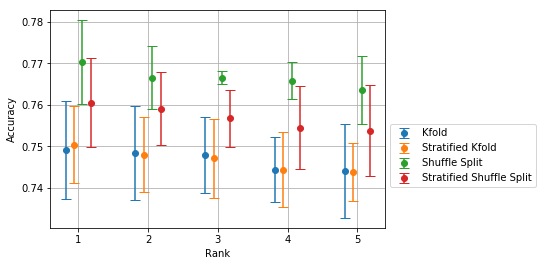

In [28]:
# #From https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot

# def rand_jitter(arr):
#     stdev = .01*(max(arr)-min(arr))
#     return arr + np.random.randn(len(arr)) * stdev

# def jitter(x, y, stds, fmt='o'):
#     return plt.errorbar(rand_jitter(x), y, stds, fmt = fmt)

def acc(x, y):
    '''Calculate the accuracy given the truth and the prediction
    '''
    mask = np.isfinite(x[:]) & np.isfinite(y[:])
    return  (x == y).sum()/x.size


jiggler = -0.18
gcs = [gc, gc2, gc3, gc4]
cvs = ['Kfold','Stratified Kfold','Shuffle Split','Stratified Shuffle Split']
for g, cv in zip(gcs, cvs):
    results = g.cv_results_
    max5_index = np.array(results['mean_test_score']).argsort()[-5:][::-1]
    means = np.array(results['mean_test_score'])[max5_index]
    stds = np.array(results['std_test_score'])[max5_index]
    plt.errorbar(np.arange(1, 6) + jiggler, means, stds, fmt = 'o', barsabove=True, capsize = 5, label = cv)
    jiggler += 0.12
    print('Accuracy for', cv, ':', acc(g.predict(cla_test[0]), cla_test[1]))
plt.xlabel('Rank')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()

We compute the confusion matricies for our CV schemes.

In [29]:
for g, cv in zip(gcs, cvs):
    print('Confusion matrix for',cv,':\n',confusion_matrix(cla_test[1], g.predict(cla_test[0])))

Confusion matrix for Kfold :
 [[511  43]
 [153 123]]
Confusion matrix for Stratified Kfold :
 [[511  43]
 [153 123]]
Confusion matrix for Shuffle Split :
 [[511  43]
 [153 123]]
Confusion matrix for Stratified Shuffle Split :
 [[511  43]
 [153 123]]


### Method 2. Random Forests

One of the more important feature of a random forest is the number of trees in the ensemble. We will also experiment with the maximum depth of the trees.

In [30]:
from sklearn.ensemble import RandomForestRegressor

We now do a grid search over n_estimators and max_depth, listing the accuracy and SD with a number of hyperparameter combinations.

In [31]:
#WARNING: THIS CELL TAKES A WHILE TO RUN
rf = RandomForestRegressor()
parameters = {'n_estimators': [10, 50, 150, 200, 300], 'max_depth': [10, 50, 100]}

gcrf = GridSearchCV(rf, parameters, cv=5)
gcrf.fit(*reg_train) #guessing you fit the regression data
results = gcrf.cv_results_

/Users/kevinmarroquin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/kevinmarroquin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/kevinmarroquin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/kevinmarroquin/anaconda3/lib/python3.6/site-packages/sklearn/model_selec

/Users/kevinmarroquin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/kevinmarroquin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/kevinmarroquin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/kevinmarroquin/anaconda3/lib/python3.6/site-packages/sklearn/model_selec

/Users/kevinmarroquin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/kevinmarroquin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/kevinmarroquin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/kevinmarroquin/anaconda3/lib/python3.6/site-packages/sklearn/model_selec

In [32]:
print('Best mean_test_score', ':', results['params'][np.argmax(results['mean_test_score'])])
print(results['mean_test_score'][np.argmax(results['mean_test_score'])], '±', results['std_test_score'][np.argmax(results['mean_test_score'])])

Best mean_test_score : {'max_depth': 100, 'n_estimators': 200}
0.5884161305650496 ± 0.03175345043167106


In [33]:
results['params']

[{'max_depth': 10, 'n_estimators': 10},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 150},
 {'max_depth': 10, 'n_estimators': 200},
 {'max_depth': 10, 'n_estimators': 300},
 {'max_depth': 50, 'n_estimators': 10},
 {'max_depth': 50, 'n_estimators': 50},
 {'max_depth': 50, 'n_estimators': 150},
 {'max_depth': 50, 'n_estimators': 200},
 {'max_depth': 50, 'n_estimators': 300},
 {'max_depth': 100, 'n_estimators': 10},
 {'max_depth': 100, 'n_estimators': 50},
 {'max_depth': 100, 'n_estimators': 150},
 {'max_depth': 100, 'n_estimators': 200},
 {'max_depth': 100, 'n_estimators': 300}]

Let's make plots to determine which parameters affect our performance the most.

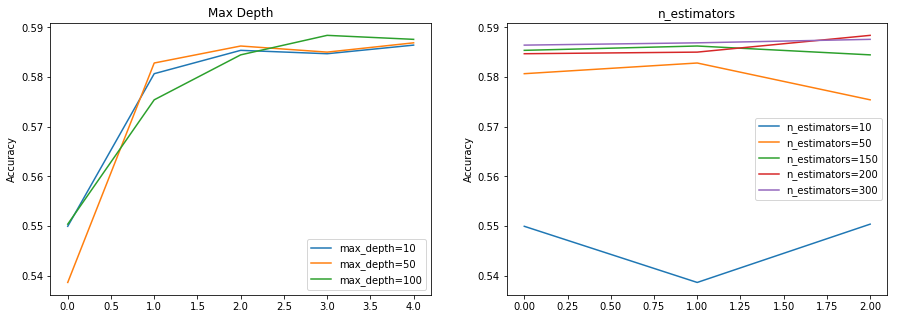

In [34]:
#Our main event!
mts = results['mean_test_score']

#Creating indecies
maxdep10 = np.array([i['max_depth'] == 10 for i in results['params']])
maxdep50 = np.array([i['max_depth'] == 50 for i in results['params']])
maxdep100 = np.array([i['max_depth'] == 100 for i in results['params']])

esti10 = np.array([i['n_estimators'] == 10 for i in results['params']])
esti50 = np.array([i['n_estimators'] == 50 for i in results['params']])
esti150 = np.array([i['n_estimators'] == 150 for i in results['params']])
esti200 = np.array([i['n_estimators'] == 200 for i in results['params']])
esti300 = np.array([i['n_estimators'] == 300 for i in results['params']])


plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)

plt.plot(mts[maxdep10], label = 'max_depth=10')
plt.plot(mts[maxdep50], label = 'max_depth=50')
plt.plot(mts[maxdep100], label = 'max_depth=100')
plt.title('Max Depth')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)

plt.plot(mts[esti10], label = 'n_estimators=10')
plt.plot(mts[esti50], label = 'n_estimators=50')
plt.plot(mts[esti150], label = 'n_estimators=150')
plt.plot(mts[esti200], label = 'n_estimators=200')
plt.plot(mts[esti300], label = 'n_estimators=300')


plt.title('n_estimators')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

That being said, we should be careful in blindly increasing max_depth and n_estimators. This can lead to obvious overfitting that can affect our performance.

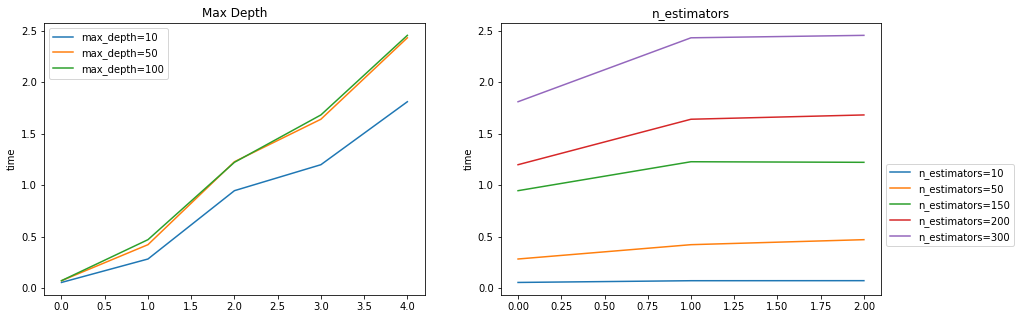

In [35]:
mft = results['mean_fit_time']

plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)

plt.plot(mft[maxdep10], label = 'max_depth=10')
plt.plot(mft[maxdep50], label = 'max_depth=50')
plt.plot(mft[maxdep100], label = 'max_depth=100')
plt.title('Max Depth')
plt.ylabel('time')
plt.legend()

plt.subplot(1,2,2)

plt.plot(mft[esti10], label = 'n_estimators=10')
plt.plot(mft[esti50], label = 'n_estimators=50')
plt.plot(mft[esti150], label = 'n_estimators=150')
plt.plot(mft[esti200], label = 'n_estimators=200')
plt.plot(mft[esti300], label = 'n_estimators=300')

plt.title('n_estimators')
plt.ylabel('time')
plt.legend(bbox_to_anchor=(1, 0.5))

plt.show()

After making some new plots I highly recommend a max depth of 10 with 150 trees. Using this to test my results with rms:

In [36]:
def rms(x, y, scale1=None, scale2=None):
    '''Calculate the rms error given the truth and the prediction
    '''
    mask = np.isfinite(x[:]) & np.isfinite(y[:])
    if scale1 is not None:
        x= scale1.inverse_transform(x)
    if scale2 is not None:
        y = scale2.inverse_transform(y)
    return  np.sqrt(np.mean((x[mask] - y[mask]) ** 2))

rms(gcrf.predict(reg_test[0]).reshape((907,1)), reg_test[1]) #Not sure why I had to reshape it

0.6277257681787554

#### Classification



In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
#Grid search (This will take few minutes)

rfc = RandomForestClassifier()
parameters = {'n_estimators': [10, 50, 150, 200, 300], 'max_depth': [10, 50, 100]} 

gcrfc = GridSearchCV(rfc, parameters, cv=StratifiedShuffleSplit(4, 0.1, random_state = 100))


In [39]:
gcrfc.fit(*cla_train) #guessing you fit the classification data
results = gcrfc.cv_results_

We do another grid search for all of our CVs:

In [40]:
print('Best mean_test_score', ':', results['params'][np.argmax(results['mean_test_score'])])
print(results['mean_test_score'][np.argmax(results['mean_test_score'])], 
      '±', results['std_test_score'][np.argmax(results['mean_test_score'])])

Best mean_test_score : {'max_depth': 50, 'n_estimators': 200}
0.7635542168674698 ± 0.01286747552005652


And compute the confusion matrix of our results:

In [41]:
cvs = [gcrf, gcrfc]
for g, cv in zip(gcs, cvs):
    print('Confusion matrix for',cv,':\n',confusion_matrix(cla_test[1], g.predict(cla_test[0])))

Confusion matrix for GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 50, 150, 200, 300], 'max_depth': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0) :
 [[511  43]
 [153 123]]
Confusion matrix for GridSearchCV(cv=StratifiedShuffleSplit(n_splits=4, random_state=100, test_size=0.1,
            train_size=None),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, cr

***